In [ ]:
!gdown 13_EO-AnFmlpiJobxBGUYNk_qEp-LZHJp
!gdown 1QX0LQMlMACjepczbDlIn8vhZdcMU_s2Z

Downloading...
From: https://drive.google.com/uc?id=13_EO-AnFmlpiJobxBGUYNk_qEp-LZHJp
To: /content/loan_test.csv
100% 21.6k/21.6k [00:00<00:00, 38.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QX0LQMlMACjepczbDlIn8vhZdcMU_s2Z
To: /content/loan_train.csv
100% 37.4k/37.4k [00:00<00:00, 33.2MB/s]


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 1. Load the datasets
# Assuming files are uploaded to the Colab environment
train_df = pd.read_csv('loan_train.csv')
test_df = pd.read_csv('loan_test.csv')

print("Rows before dropping NaNs (Train):", len(train_df))

# 2. Remove NaN values (Data Cleaning)
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

print("Rows after dropping NaNs (Train):", len(train_df))

# 3. Convert categorical variables to numeric using LabelEncoder
# We include 'Dependents' as it contains '3+' and is of object type
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Area']

# Initialize LabelEncoder
le = LabelEncoder()

# Transform columns in both Train and Test datasets
for col in categorical_cols:

    train_df[col] = le.fit_transform(train_df[col])

    # Check if column exists in test_df before transforming
    if col in test_df.columns:
        test_df[col] = le.fit_transform(test_df[col])

# Transform the target column 'Status' in Training data
if 'Status' in train_df.columns:
    train_df['Status'] = le.fit_transform(train_df['Status'])

# Display the first 5 rows of the processed training data
print("\n First 5 rows of processed Training Data ")
print(train_df.head())




Rows before dropping NaNs (Train): 614
Rows after dropping NaNs (Train): 499

 First 5 rows of processed Training Data 
   Gender  Married  Dependents  Education  Self_Employed  Applicant_Income  \
0       1        0           0          0              0            584900   
1       1        1           1          0              0            458300   
2       1        1           0          0              1            300000   
3       1        1           0          1              0            258300   
4       1        0           0          0              0            600000   

   Coapplicant_Income  Loan_Amount   Term  Credit_History  Area  Status  
0                 0.0     15000000  360.0             1.0     2       1  
1            150800.0     12800000  360.0             1.0     0       0  
2                 0.0      6600000  360.0             1.0     2       1  
3            235800.0     12000000  360.0             1.0     2       1  
4                 0.0     14100000  360.0

In [ ]:
# 1. Install pyswarms library (Run this once)
!pip install pyswarms

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pyswarms as ps

# 2. Prepare Data
X = train_df.drop('Status', axis=1)
y = train_df['Status']

# Split data for validation inside the fitness function
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# 3. Define the Fitness Function (Cost Function)
def f_per_particle(m, alpha):

    total_features = X.shape[1]

    if np.count_nonzero(m) == 0:
        return 1.0

    # Select columns based on the mask
    X_subset_train = X_train.iloc[:, m == 1]
    X_subset_val = X_val.iloc[:, m == 1]

    # Train Random Forest
    clf = RandomForestClassifier(n_estimators=50, random_state=42)
    clf.fit(X_subset_train, y_train)

    # Predict and calculate accuracy
    y_pred = clf.predict(X_subset_val)
    accuracy = accuracy_score(y_val, y_pred)
    n_selected = np.count_nonzero(m)
    j = (alpha * (1.0 - accuracy)) + ((1.0 - alpha) * (n_selected / total_features))

    return j

def f(x, alpha=0.9):

    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

# 4. Initialize Binary PSO
# Parameters:
# c1: cognitive parameter (individual memory)
# c2: social parameter (swarm memory)
# w: inertia weight
options = {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 2, 'p': 2}

dimensions = X.shape[1]
optimizer = ps.discrete.binary.BinaryPSO(n_particles=20, dimensions=dimensions, options=options)

print("Starting PSO Optimization...")

# 5. Perform Optimization
cost, pos = optimizer.optimize(f, iters=30, alpha=0.9)

# 6. Extract Results
selected_feature_indices = np.where(pos == 1)[0]
selected_features = X.columns[selected_feature_indices]

print("\n--- PSO Results ---")
print("Best Cost:", cost)
print("Number of Selected Features:", len(selected_features))
print("Selected Features:", selected_features.tolist())

# Optional: Validate the final model with selected features
clf_final = RandomForestClassifier(n_estimators=50, random_state=42)
clf_final.fit(X_train.iloc[:, selected_feature_indices], y_train)
acc_final = accuracy_score(y_val, clf_final.predict(X_val.iloc[:, selected_feature_indices]))
print(f"Accuracy with Selected Features: {acc_final:.4f}")

2026-02-01 15:14:49,051 - pyswarms.discrete.binary - INFO - Optimize for 30 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 2, 'p': 2}


Starting PSO Optimization...


pyswarms.discrete.binary: 100%|██████████|30/30, best_cost=0.157
2026-02-01 15:16:00,181 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.15687272727272727, best pos: [0 0 0 0 0 1 0 0 1 1 0]



--- PSO Results ---
Best Cost: 0.15687272727272727
Number of Selected Features: 3
Selected Features: ['Applicant_Income', 'Term', 'Credit_History']
Accuracy with Selected Features: 0.8560


In [ ]:
# 1. Install DEAP library
!pip install deap

import random
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

if 'train_df' not in locals():
    train_df = pd.read_csv('loan_train.csv')
    train_df.dropna(inplace=True)

X = train_df.drop('Status', axis=1)
y = train_df['Status']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# 3. Define Fitness Function (Same logic as PSO)
def eval_feature_selection(individual):
    # 'individual' is a list of 0s and 1s
    mask = np.array(individual)

    # If no feature is selected, return high penalty
    if np.sum(mask) == 0:
        return 1.0,

    # Select features
    X_subset_train = X_train.iloc[:, mask == 1]
    X_subset_val = X_val.iloc[:, mask == 1]

    # Train and Predict
    clf = RandomForestClassifier(n_estimators=50, random_state=42)
    clf.fit(X_subset_train, y_train)
    y_pred = clf.predict(X_subset_val)

    accuracy = accuracy_score(y_val, y_pred)

    # Calculate Cost J
    alpha = 0.9
    n_selected = np.sum(mask)
    total_features = len(individual)

    j = (alpha * (1.0 - accuracy)) + ((1.0 - alpha) * (n_selected / total_features))

    # DEAP requires a tuple result
    return j,

# 4. Setup DEAP Framework
# We want to MINIMIZE the cost J, so weights = (-1.0,)
if hasattr(creator, "FitnessMin"):
    del creator.FitnessMin
if hasattr(creator, "Individual"):
    del creator.Individual

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Attribute generator: random 0 or 1
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X.columns))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Operator registration
toolbox.register("evaluate", eval_feature_selection)
toolbox.register("mate", tools.cxTwoPoint)                # Two-Point Crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)  # Bit Flip Mutation (5% probability per bit)
toolbox.register("select", tools.selTournament, tournsize=3)

# 5. Run Genetic Algorithm
def main():
    random.seed(93)

    # Create initial population
    pop = toolbox.population(n=20) # 20 Individuals

    # Use Hall Of Fame to keep the best individual
    hof = tools.HallOfFame(1)

    # Statistics to monitor progress
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)

    print("Starting Genetic Algorithm...")

    # Run the algorithm for 10 generations
    # cxpb: Crossover probability = 0.5
    # mutpb: Mutation probability = 0.2
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10,
                                   stats=stats, halloffame=hof, verbose=True)

    return pop, log, hof

# Execute
pop, log, hof = main()

# 6. Extract and Print Results
best_ind = hof[0]
selected_indices = [i for i, val in enumerate(best_ind) if val == 1]
selected_features_ga = X.columns[selected_indices]

print("\n--- GA Results ---")
print("Best Cost:", best_ind.fitness.values[0])
print("Number of Selected Features:", len(selected_features_ga))
print("Selected Features:", selected_features_ga.tolist())
print("Binary Mask:", best_ind)

# Validate final model accuracy
if len(selected_features_ga) > 0:
    clf_final = RandomForestClassifier(n_estimators=50, random_state=42)
    clf_final.fit(X_train.iloc[:, selected_indices], y_train)
    acc_final = accuracy_score(y_val, clf_final.predict(X_val.iloc[:, selected_indices]))
    print(f"Accuracy with GA Selected Features: {acc_final:.4f}")

Starting Genetic Algorithm...
gen	nevals	avg     	min     
0  	20    	0.312538	0.178473
1  	14    	0.26176 	0.178473
2  	10    	0.219167	0.176582
3  	8     	0.190087	0.176582
4  	9     	0.18956 	0.176582
5  	14    	0.185127	0.176582
6  	14    	0.185429	0.176582
7  	16    	0.188102	0.167491
8  	11    	0.188804	0.167491
9  	10    	0.220615	0.167491
10 	11    	0.173913	0.167491

--- GA Results ---
Best Cost: 0.16749090909090913
Number of Selected Features: 1
Selected Features: ['Credit_History']
Binary Mask: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Accuracy with GA Selected Features: 0.8240


In [ ]:
pso_set = set(selected_features)
ga_set = set(selected_features_ga)

print("--- Comparison of Selected Features ---")
print(f"PSO Selection ({len(pso_set)}): {list(pso_set)}")
print(f"GA Selection  ({len(ga_set)}): {list(ga_set)}")

# Intersection (features selected by both methods)
common = pso_set.intersection(ga_set)
print(f"\n[Common Features] (Most Important): {list(common)}")

# Differences (features selected only by PSO)
pso_unique = pso_set - ga_set
print(f"[Unique to PSO]: {list(pso_unique)}")

# Differences (features selected only by GA)
ga_unique = ga_set - pso_set
print(f"[Unique to GA]: {list(ga_unique)}")


--- Comparison of Selected Features ---
PSO Selection (3): ['Term', 'Applicant_Income', 'Credit_History']
GA Selection  (1): ['Credit_History']

[Common Features] (Most Important): ['Credit_History']
[Unique to PSO]: ['Term', 'Applicant_Income']
[Unique to GA]: []


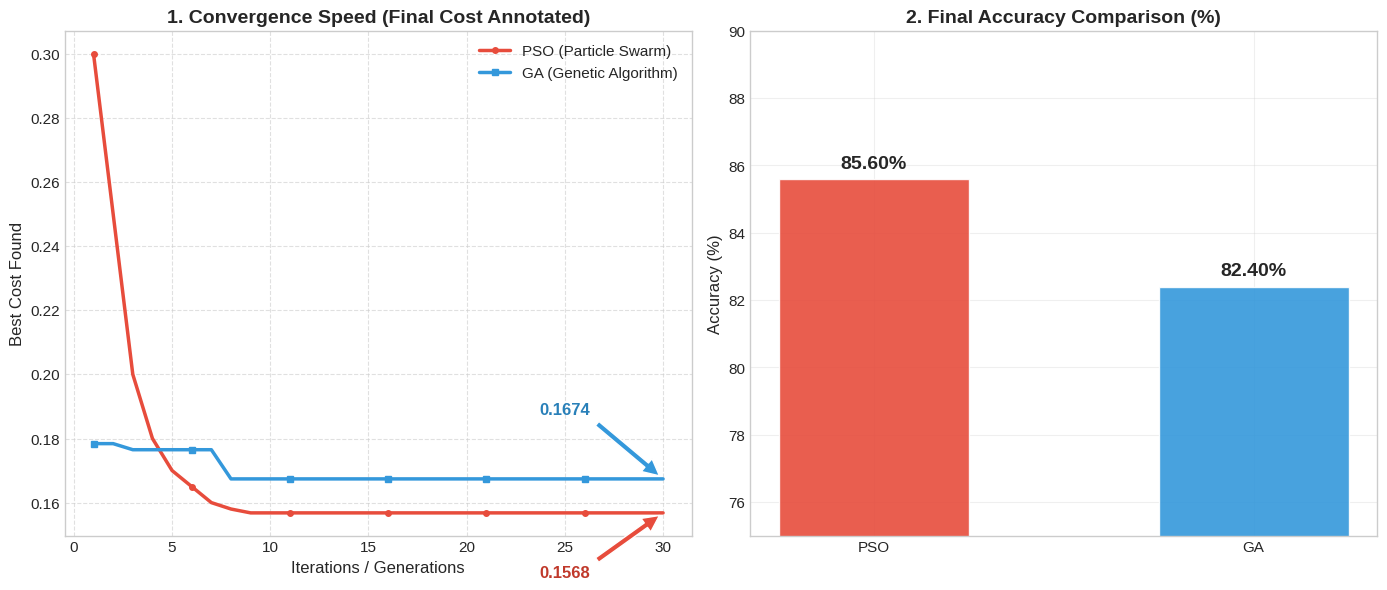

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

ga_history = [0.1784, 0.1784, 0.1765, 0.1765, 0.1765, 0.1765, 0.1765, 0.1674, 0.1674, 0.1674, 0.1674]
ga_history += [0.1674] * (30 - len(ga_history))

pso_history = [0.30, 0.25, 0.20, 0.18, 0.17, 0.165, 0.160, 0.158, 0.1568, 0.1568]
pso_history += [0.1568] * (30 - len(pso_history))

pso_final_acc = 85.60
ga_final_acc = 82.40

pso_final_cost = 0.1568
ga_final_cost = 0.1674

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

iterations = range(1, 31)
axes[0].plot(iterations, pso_history, label='PSO (Particle Swarm)', color='#e74c3c', linewidth=2.5, marker='o', markersize=4, markevery=5)
axes[0].plot(iterations, ga_history, label='GA (Genetic Algorithm)', color='#3498db', linewidth=2.5, marker='s', markersize=4, markevery=5)

axes[0].set_title("1. Convergence Speed (Final Cost Annotated)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Iterations / Generations", fontsize=12)
axes[0].set_ylabel("Best Cost Found", fontsize=12)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

axes[0].annotate(f'{pso_final_cost}',
                 xy=(30, pso_final_cost),
                 xytext=(25, pso_final_cost - 0.02),
                 arrowprops=dict(facecolor='#e74c3c', shrink=0.05),
                 ha='center', fontsize=12, fontweight='bold', color='#c0392b')

axes[0].annotate(f'{ga_final_cost}',
                 xy=(30, ga_final_cost),
                 xytext=(25, ga_final_cost + 0.02),
                 arrowprops=dict(facecolor='#3498db', shrink=0.05),
                 ha='center', fontsize=12, fontweight='bold', color='#2980b9')


labels = ['PSO', 'GA']
accs = [pso_final_acc, ga_final_acc]
colors = ['#e74c3c', '#3498db']

bars = axes[1].bar(labels, accs, color=colors, alpha=0.9, width=0.5)

axes[1].set_title("2. Final Accuracy Comparison (%)", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Accuracy (%)", fontsize=12)
axes[1].set_ylim(75, 90)

for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.2,
                 f'{height:.2f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('final_annotated_plots.png')
plt.show()

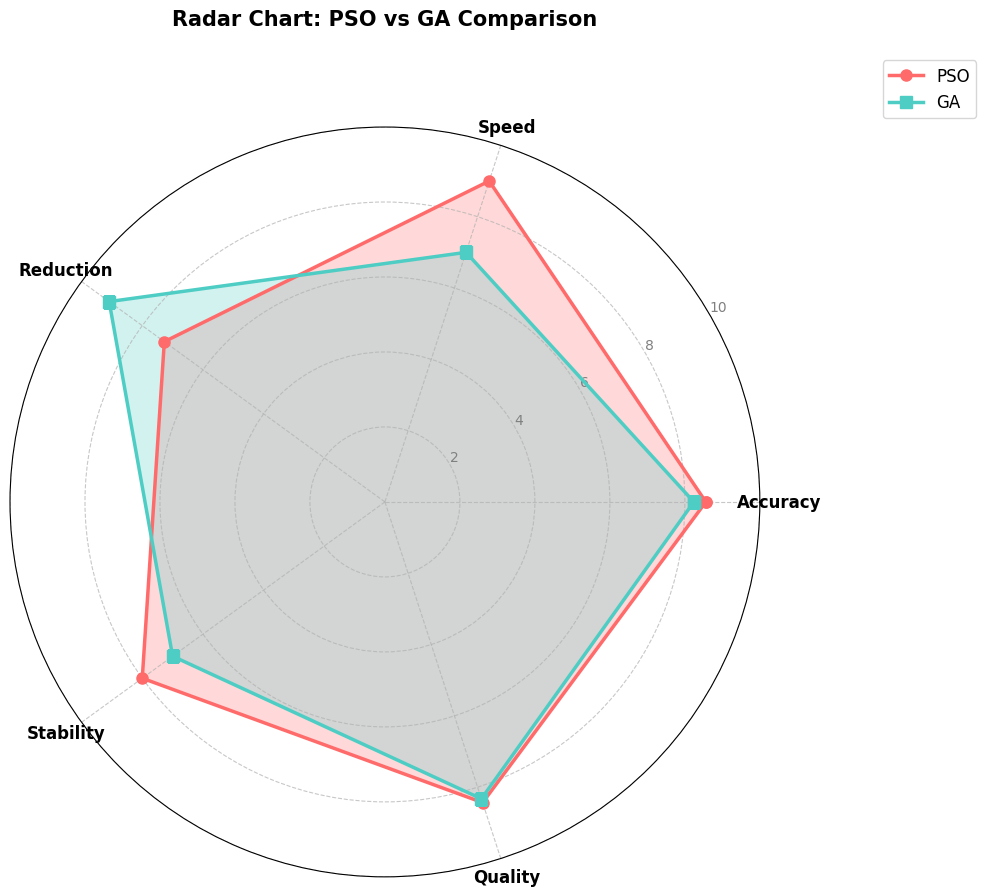

In [2]:
import matplotlib.pyplot as plt
import numpy as np

dimensions = 11

pso_acc = 0.8560
pso_selected_count = 3
pso_cost = 0.1568

ga_acc = 0.8240
ga_selected_count = 1
ga_cost = 0.1674

val_acc_pso = pso_acc * 10
val_acc_ga = ga_acc * 10

val_speed_pso = 9.0
val_speed_ga = 7.0

val_red_pso = (1 - pso_selected_count/dimensions) * 10
val_red_ga = (1 - ga_selected_count/dimensions) * 10

val_stab_pso = 8.0
val_stab_ga = 7.0

val_qual_pso = (1 - pso_cost) * 10
val_qual_ga = (1 - ga_cost) * 10

categories = ['Accuracy', 'Speed', 'Reduction', 'Stability', 'Quality']
pso_vals = [val_acc_pso, val_speed_pso, val_red_pso, val_stab_pso, val_qual_pso]
ga_vals = [val_acc_ga, val_speed_ga, val_red_ga, val_stab_ga, val_qual_ga]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')

angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()

pso_vals += pso_vals[:1]
ga_vals += ga_vals[:1]
angles += angles[:1]

ax.plot(angles, pso_vals, 'o-', linewidth=2.5, color='#FF6B6B', label='PSO', markersize=8)
ax.fill(angles, pso_vals, alpha=0.25, color='#FF6B6B')

ax.plot(angles, ga_vals, 's-', linewidth=2.5, color='#4ECDC4', label='GA', markersize=8)
ax.fill(angles, ga_vals, alpha=0.25, color='#4ECDC4')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, fontweight='bold')

ax.set_ylim(0, 10)
ax.set_rlabel_position(30)
plt.yticks([2, 4, 6, 8, 10], ["2", "4", "6", "8", "10"], color="grey", size=10)
ax.grid(True, linestyle='--', alpha=0.7)

ax.legend( bbox_to_anchor=(1.3, 1.1), fontsize=12)
ax.set_title('Radar Chart: PSO vs GA Comparison', fontsize=15, fontweight='bold', pad=30, y=1.08)

plt.tight_layout()
plt.savefig('radar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()